# Group Project 4

imports 

In [1343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


read in EPA air_quality .csv files

In [1279]:
# # read in each CSV file in air_quality_data directory and concatenate them into one dataframe
# air_quality_data = pd.concat([pd.read_csv('air_quality_data/{}'.format(file)) for file in os.listdir('air_quality_data')])

# life expectancy data by CA county
life_expectancy = pd.read_csv('health_data/Vital_Signs_Life_Expectancy_by_county.csv')

# mortality tables for CA counties from 2014-2022
mortality = pd.read_csv('health_data/mortality.csv')

# mortality tables for CA counties from 1999-2013
mortality_2 = pd.read_csv('health_data/99-13_mortality.csv')

# concatenate the two mortality tables
mortality = pd.concat([mortality, mortality_2]).sort_values(by='Year').reset_index(drop=True)

# 5 year cancer incidence rates by CA county
cancer_incidence = pd.read_csv('health_data/incd.csv')

In [1324]:
# clean cancer incidence data

# remove (7) from every county name
cancer_incidence['County'] = cancer_incidence['County'].str.replace(r'\(.*\)', '', regex=True).str.strip()

# remove "County" from every county name
cancer_incidence['County'] = cancer_incidence['County'].str.replace('County', '', regex=False).str.strip()

# filter for only counties in ca_df['County].unique()
cancer_incidence = cancer_incidence[cancer_incidence['County'].isin(air_quality_data['County'].unique())]

# add 2019 as year
cancer_incidence['Year'] = 2019

Filter `air_quality_data` down to only California

In [1325]:
# filter for only California 
ca_df = air_quality_data.query('State == "California"').copy()

# Set the index to be the year
ca_df.set_index('Year', inplace=True)

ca_df = ca_df.query('`Days with AQI` > 360').copy()

In [1326]:
ca_df.head()

,State,County,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
Year,,,,,,,,,,,,,,,,,
1999,California,Alameda,365,258,81,19,5,2,0,212,87,41,4,142,166,52,1
1999,California,Amador,365,212,89,53,10,1,0,202,122,45,6,0,359,0,0
1999,California,Butte,365,237,98,23,7,0,0,187,97,44,7,84,223,29,22
1999,California,Calaveras,365,196,104,49,15,1,0,201,129,48,1,0,349,15,0
1999,California,Colusa,365,235,110,20,0,0,0,150,87,44,0,0,283,31,51


<AxesSubplot:title={'center':'Good AQ Days in California by Year'}, xlabel='Year'>

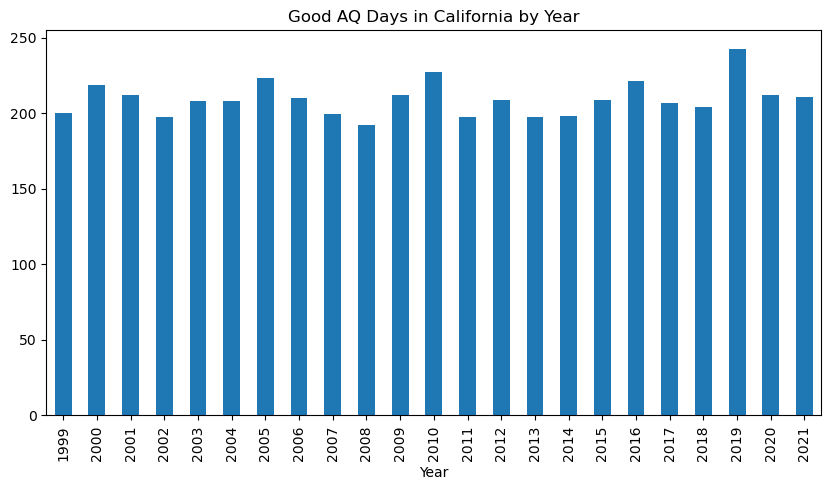

In [1327]:
# aggregate Unheathy Days by year
unhealthy_days = ca_df.groupby('Year')['Good Days'].mean()

# plot the data
unhealthy_days.plot(kind='bar', figsize=(10, 5), title='Good AQ Days in California by Year')

# CA Mortality Statistics

| Abbreviation | Cause of Death |
| --- | --- |
| ALL | All causes (total) |
| ALZ | Alzheimer's disease [G30] |
| CAN | Malignant neoplasms (cancers) [C00-C97] |
| CLD | Chronic lower respiratory disease (CLRD) [J40-J47] |
| DIA | Diabetes mellitus [E10-E14] |
| HOM | Assault (homicide) [*U01-*U02, X85-Y09, Y87.1] |
| HTD | Diseases of heart [I00-I09, I11, I13, I20-I51] |
| HYP | Essential hypertension and hypertensive renal disease [I10, I12, I15] |
| INJ | Accidents (unintentional injuries) [V01-X59, Y85-Y86] |
| LIV | Chronic liver disease and cirrhosis [K70, K73-K74] |
| NEP | Nephritis, nephrotic syndrome and nephrosis [N00-N07, N17-N19, N25-N27] |
| PAR | Parkinson's disease [G20-G21] |
| PNF | Pneumonia and influenza [J09-J18] |
| STK | Cerebrovascular disease (stroke) [I60-I69] |
| SUI | Intentional self-harm (suicide) [*U03, X60-X84, Y87.0] |


In [1328]:
# deaths likely attributable to air pollution
respiratory_diseases = ['CLD', 'CAN', 'PNF', 'HTD']

In [1329]:
mortality

,Year,County,Geography_Type,Strata,Strata_Name,Cause,Cause_Desc,ICD_Revision,Count,Annotation_Code,Annotation_Desc,Data_Revision_Date
0,1999,Sierra,Residence,Gender,Female,HTD,Diseases of heart,NaN,NaN,1.0,Cell suppressed for small numbers,NaN
1,1999,Madera,Residence,Total Population,Total Population,DIA,Diabetes mellitus,NaN,28.0,NaN,NaN,NaN
2,1999,Madera,Residence,Gender,Male,CLD,Chronic lower respiratory diseases,NaN,34.0,NaN,NaN,NaN
3,1999,Madera,Residence,Gender,Female,CLD,Chronic lower respiratory diseases,NaN,20.0,NaN,NaN,NaN
4,1999,Madera,Residence,Total Population,Total Population,CLD,Chronic lower respiratory diseases,NaN,54.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
462951,2021,San Joaquin,Occurrence,Gender,Female,LIV,Chronic liver disease and cirrhosis,ICD-10,49.0,NaN,NaN,12/15/2022
462952,2021,San Joaquin,Occurrence,Total Population,Total Population,LIV,Chronic liver disease and cirrhosis,ICD-10,165.0,NaN,NaN,12/15/2022
462953,2021,San Joaquin,Occurrence,Race-Ethnicity,Other/Unknown,INJ,Accidents (unintentional injuries),ICD-10,17.0,NaN,NaN,12/15/2022
462954,2021,San Joaquin,Occurrence,Race-Ethnicity,Hawaiian/Pacific Islander,NEP,"Nephritis, nephrotic syndrome and nephrosis",ICD-10,NaN,1.0,Cell suppressed for small numbers,12/15/2022


In [1330]:
# create a df for each disease
cld = mortality.query('Cause == "CLD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()
can = mortality.query('Cause == "CAN" and Strata == "Total Population" and Geography_Type == "Residence"').copy()
pneumonia = mortality.query('Cause == "PNF" and Strata == "Total Population" and Geography_Type == "Residence"').copy()
heart_disease = mortality.query('Cause == "HTD" and Strata == "Total Population" and Geography_Type == "Residence"').copy()


In [1331]:
# only want full data
ca_df = ca_df.query('`Days with AQI` > 360').copy()
# merge cld and ca_df
cld = cld.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])
# merge can and ca_df
can = can.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])
# merge pneumonia and ca_df
pneumonia = pneumonia.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])
# merge heart_disease and ca_df
heart_disease = heart_disease.merge(ca_df, how='left', left_on=['County', 'Year'], right_on=['County', 'Year'])

# query dataframes so count is greater than 0
cld = cld.query('Count > 0')
can = can.query('Count > 0')
pneumonia = pneumonia.query('Count > 0')
heart_disease = heart_disease.query('Count > 0')


In [1332]:
# impute missing values with 0
cld.fillna(0, inplace=True)
can.fillna(0, inplace=True)
pneumonia.fillna(0, inplace=True)
heart_disease.fillna(0, inplace=True)


# EDA

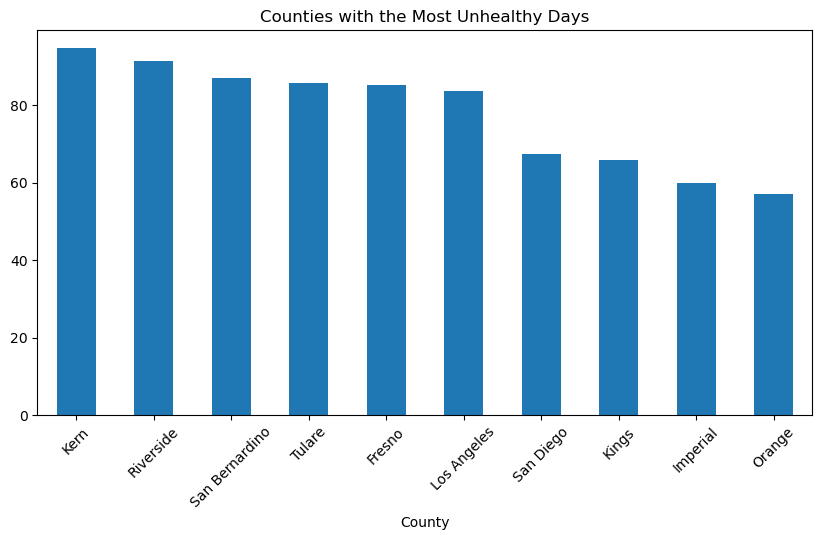

In [1333]:
# counties with the most unhealthy days
counties_worst_air_qual = ca_df.groupby('County')['Median AQI'].mean().sort_values(ascending=False).head(10)

counties_worst_air_qual.plot(kind='bar', figsize=(10, 5), title='Counties with the Most Unhealthy Days')
plt.xticks(rotation=45);

In [1334]:
mortality.head()

,Year,County,Geography_Type,Strata,Strata_Name,Cause,Cause_Desc,ICD_Revision,Count,Annotation_Code,Annotation_Desc,Data_Revision_Date
0,1999,Sierra,Residence,Gender,Female,HTD,Diseases of heart,NaN,NaN,1.0,Cell suppressed for small numbers,NaN
1,1999,Madera,Residence,Total Population,Total Population,DIA,Diabetes mellitus,NaN,28.0,NaN,NaN,NaN
2,1999,Madera,Residence,Gender,Male,CLD,Chronic lower respiratory diseases,NaN,34.0,NaN,NaN,NaN
3,1999,Madera,Residence,Gender,Female,CLD,Chronic lower respiratory diseases,NaN,20.0,NaN,NaN,NaN
4,1999,Madera,Residence,Total Population,Total Population,CLD,Chronic lower respiratory diseases,NaN,54.0,NaN,NaN,NaN


In [1335]:
def plot_air_quality_by_county(county, air_qual, diseases):
    """
    Plots the number of deaths from a specified set of diseases in a given county, 
    and the amount of specified air quality days in that county, on separate subplots.
    
    Args:
        county (str): The name of the county to plot data for.
        air_qual (str): The type of air quality to plot data for.
        diseases (list): A list of strings representing the names of the diseases to plot data for.
    """
    # create figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # query mortality df
    mortality.query(f'County == "{county}" and Strata == "Total Population" and Cause in {diseases}').groupby('Year')['Count'].sum().plot(kind='line', figsize=(10, 5), title=f'Deaths from {diseases} in {county} by Year', ax=ax[0])
    

    # overlay line plot of unhealthy days from ca_df log scale
    ca_df.query(f'County == "{county}"').groupby('Year')[air_qual].sum().plot(kind='line', figsize=(10, 5), title=f'{air_qual} in {county} by Year', ax=ax[1], color='red')

    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()

# function to plot correlation matrix for air quality and disease df
def get_correlation_plot(df, title):
    """
    Plots the upper triangle of the correlation matrix for a given dataframe.
    
    Args:
        df (pd.DataFrame): The dataframe to plot the correlation matrix for.
    """
    # create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # plot heatmap
    sns.heatmap(df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=np.triu(df, k=1), ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    # tight layout
    plt.tight_layout()
    
    # close figure
    plt.show()
    plt.close()


# Granger Causality Tests

In [1336]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform the Granger causality test
maxlag = 2 # number of lags to consider

# Null hypothesis: x does not Granger cause y
# Alternative hypothesis: x Granger causes y

def air_qual_test(df, air_qual_stat):
    for county in counties_worst_air_qual.index:
        # perform granger causality test
        result = grangercausalitytests(can.query(f'County == "{county}"')[['Count', air_qual_stat]], maxlag=maxlag, verbose=False)
        # get lag 1 p values
        lag1 = np.array([result[1][0][key][1] for key in result[1][0].keys()]).mean()
        # get lag 2 p values
        lag2 = np.array([result[2][0][key][1] for key in result[1][0].keys()]).mean()
        # alpha = 0.05 
        if lag1 < 0.05:
            print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from cancerous diseases in {county} county with p_value of {lag1} and lag of 1')
            return county, air_qual_stat, lag1, 1, df['Cause'].unique()[0]
        elif lag2 < 0.05:
            print(f'Air Quality metric: ({air_qual_stat}) Granger causes deaths from cancerous diseases in {county} county with p_value of {lag2} and lag of 2')
            return county, air_qual_stat, lag2, 2, df['Cause'].unique()[0]
        else:
            pass

counties = []
# test for each air quality stat
    # add dicts to counties dict
for df in [cld, can, pneumonia, heart_disease]:
    for air_qual_stat in ['Days PM2.5', 'Days NO2', 'Days Ozone', 'Days PM10', 'Unhealthy Days', 'Median AQI']:
        counties.append(air_qual_test(df, air_qual_stat))
        

granger_df = pd.DataFrame(counties, columns=['County','air_qual_metric','p_value', 'lag', 'Cause'])

granger_df.sort_values(by='County', ascending=True, inplace=True)

granger_df

Air Quality metric: (Days PM2.5) Granger causes deaths from cancerous diseases in Los Angeles county with p_value of 0.0037490376870667587 and lag of 1
Air Quality metric: (Days NO2) Granger causes deaths from cancerous diseases in Kern county with p_value of 0.00869045902825357 and lag of 1
Air Quality metric: (Days Ozone) Granger causes deaths from cancerous diseases in Los Angeles county with p_value of 0.025781577200156863 and lag of 2
Air Quality metric: (Days PM10) Granger causes deaths from cancerous diseases in Tulare county with p_value of 0.04034862252476891 and lag of 1
Air Quality metric: (Unhealthy Days) Granger causes deaths from cancerous diseases in Kern county with p_value of 0.004728206286322732 and lag of 1
Air Quality metric: (Median AQI) Granger causes deaths from cancerous diseases in San Bernardino county with p_value of 0.0057598656428352974 and lag of 2
Air Quality metric: (Days PM2.5) Granger causes deaths from cancerous diseases in Los Angeles county with p_v

,County,air_qual_metric,p_value,lag,Cause
16,Kern,Unhealthy Days,0.004728,1,PNF
1,Kern,Days NO2,0.008690,1,CLD
13,Kern,Days NO2,0.008690,1,PNF
4,Kern,Unhealthy Days,0.004728,1,CLD
19,Kern,Days NO2,0.008690,1,HTD
7,Kern,Days NO2,0.008690,1,CAN
22,Kern,Unhealthy Days,0.004728,1,HTD
10,Kern,Unhealthy Days,0.004728,1,CAN
14,Los Angeles,Days Ozone,0.025782,2,PNF
12,Los Angeles,Days PM2.5,0.003749,1,PNF


# Correlation Plots

In [1337]:
# numeric columns in ca_df
numeric_cols = ['Good Days', 'Moderate Days', 'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI', 'Days CO', 'Days NO2', 'Days Ozone', 'Days PM2.5', 'Days PM10', 'Days with AQI', 'Count', 'Median AQI']

# query for worst counties for each disease
cld_corr = cld.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

can_corr = can.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

pneumonia_corr = pneumonia.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()

heart_disease_corr = heart_disease.query('County in @counties_worst_air_qual.index')[numeric_cols].corr()


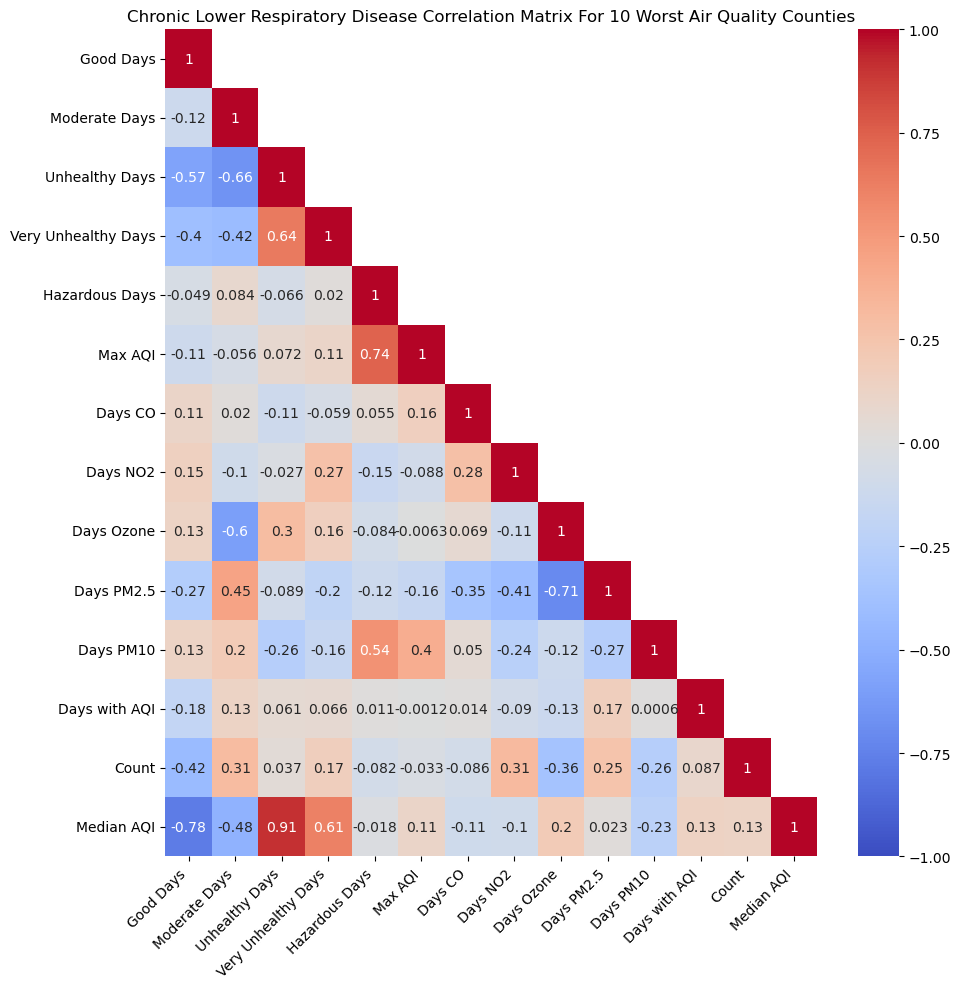

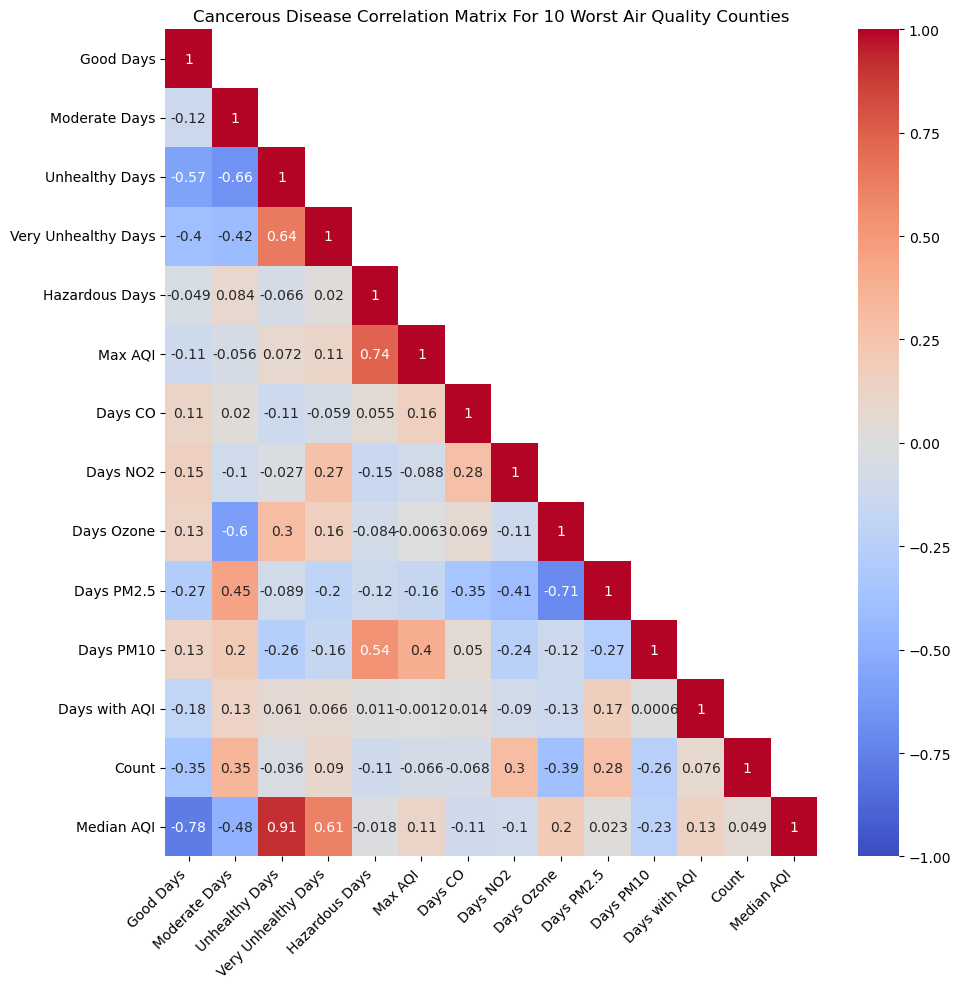

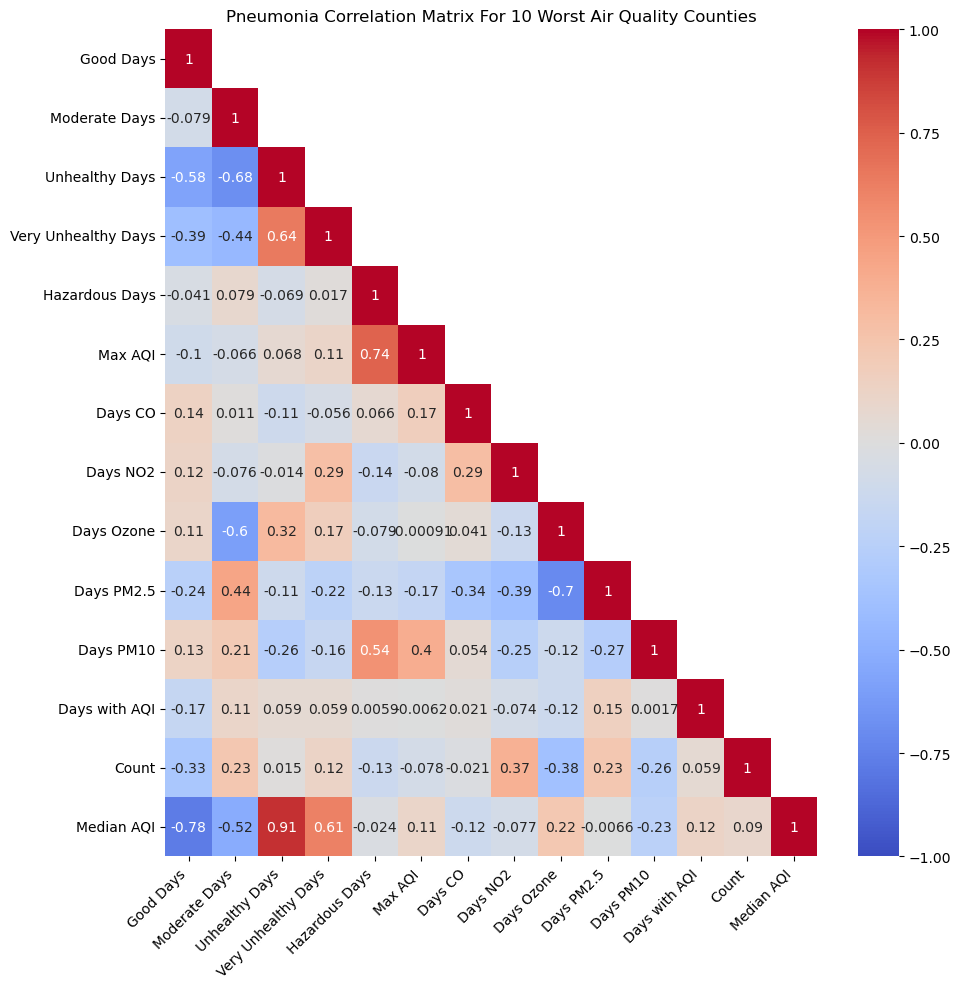

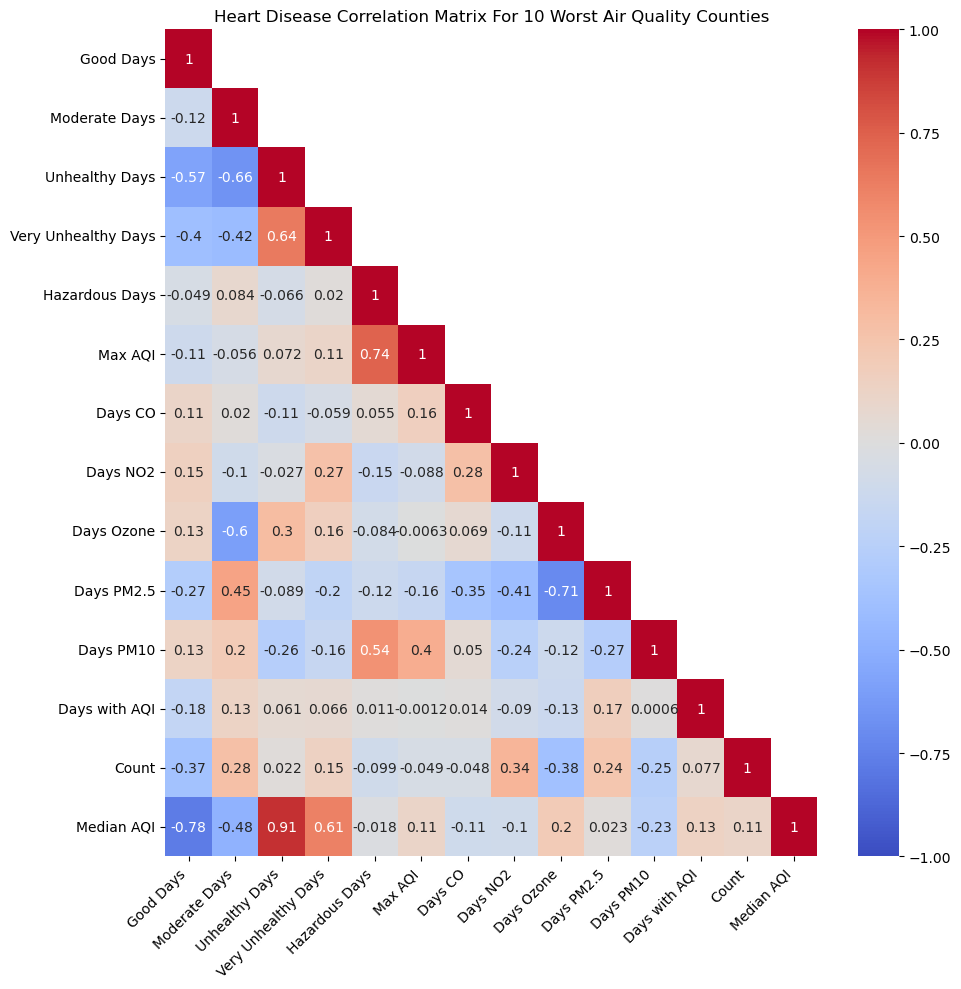

In [1338]:

# CLD
get_correlation_plot(cld_corr, 'Chronic Lower Respiratory Disease Correlation Matrix For 10 Worst Air Quality Counties')

# CAN
get_correlation_plot(can_corr, 'Cancerous Disease Correlation Matrix For 10 Worst Air Quality Counties')

# PNF
get_correlation_plot(pneumonia_corr, 'Pneumonia Correlation Matrix For 10 Worst Air Quality Counties')

# HTD
get_correlation_plot(heart_disease_corr, 'Heart Disease Correlation Matrix For 10 Worst Air Quality Counties')

# Line Plots

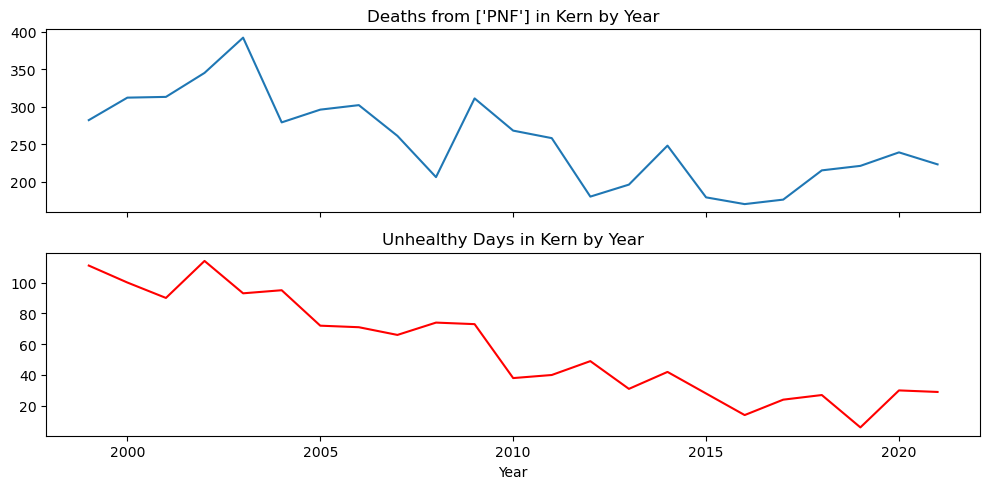

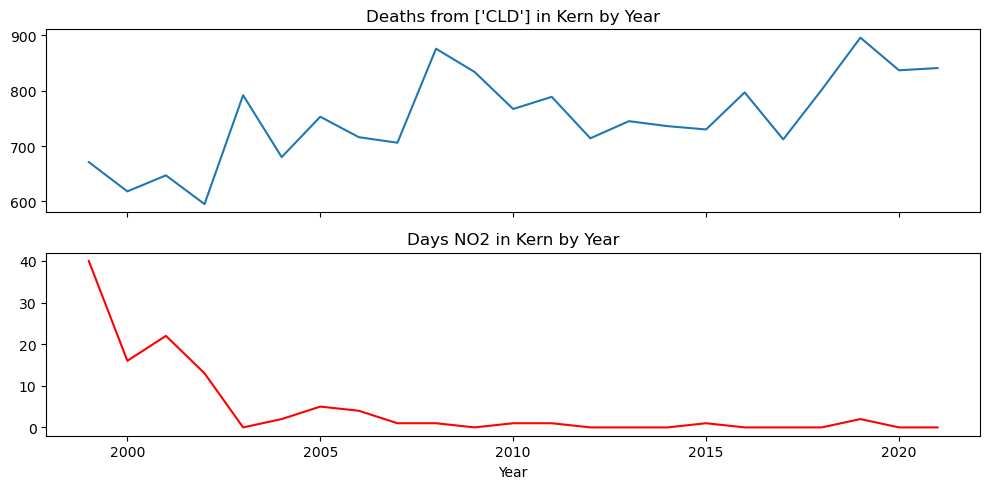

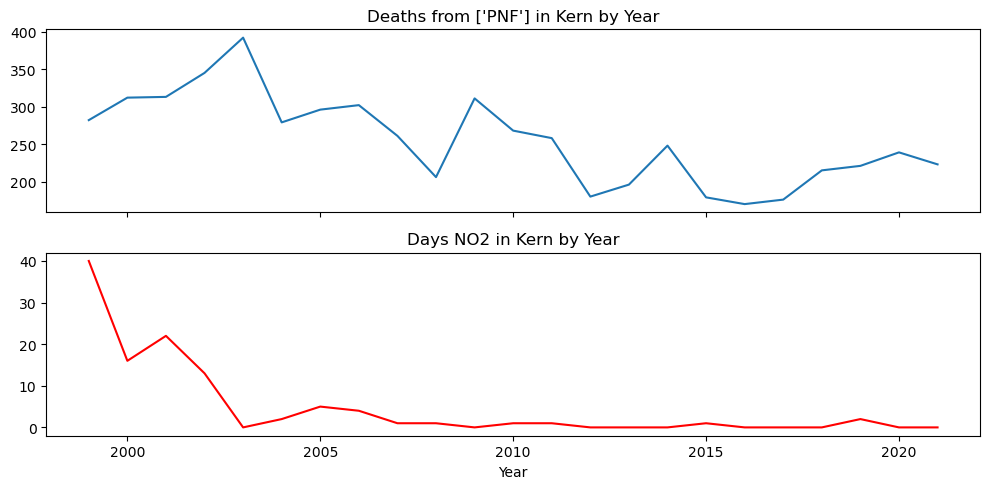

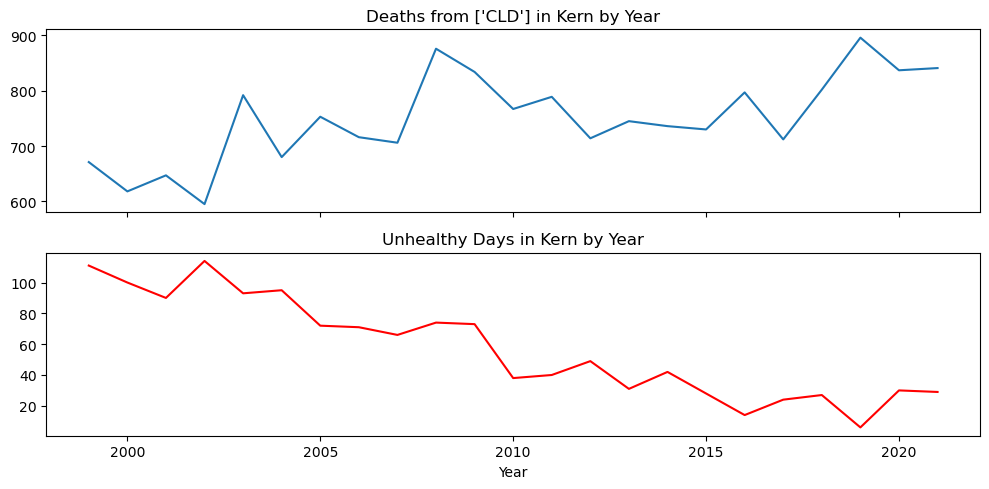

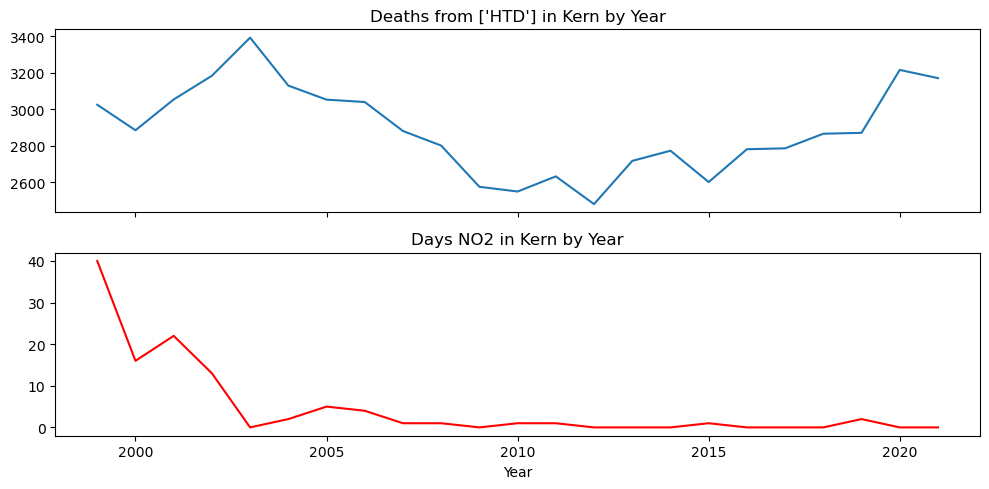

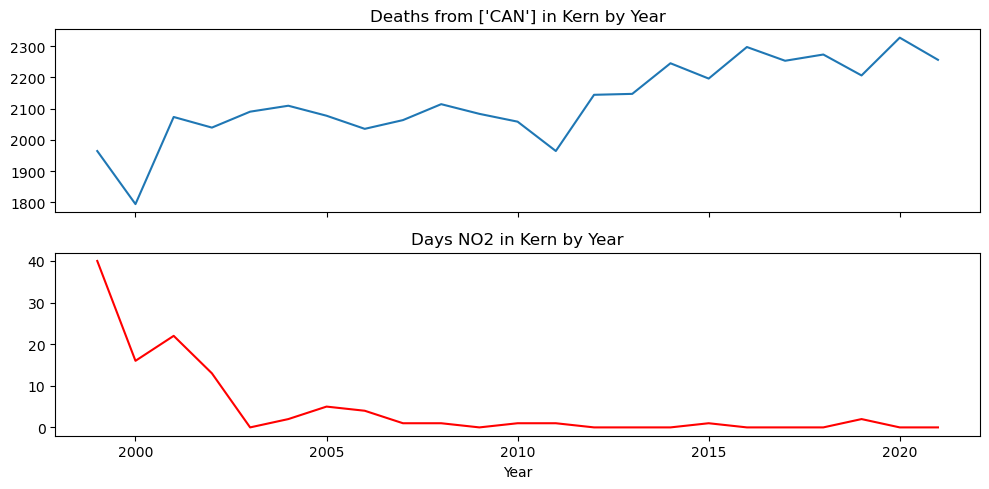

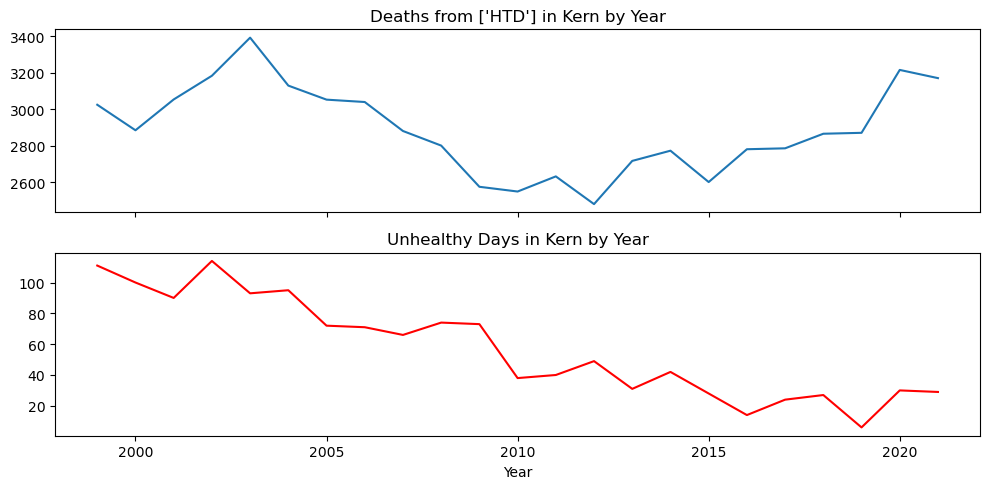

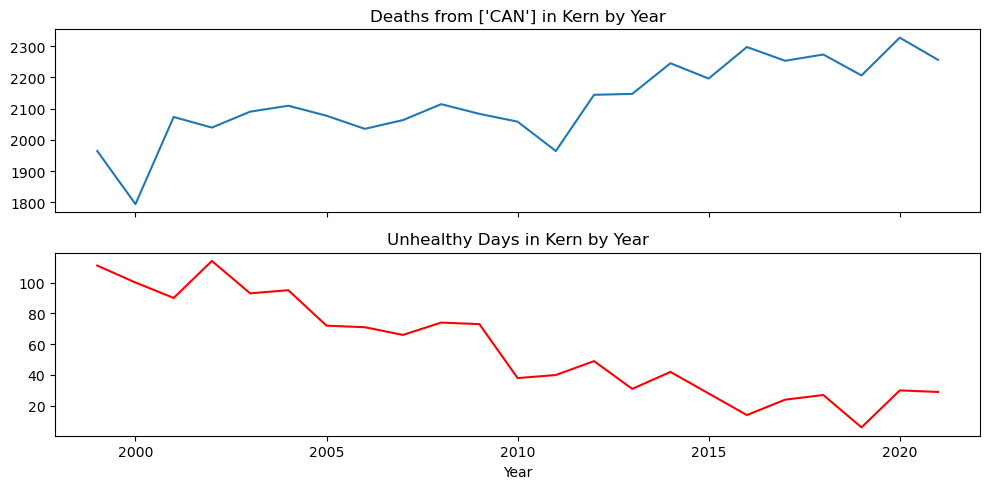

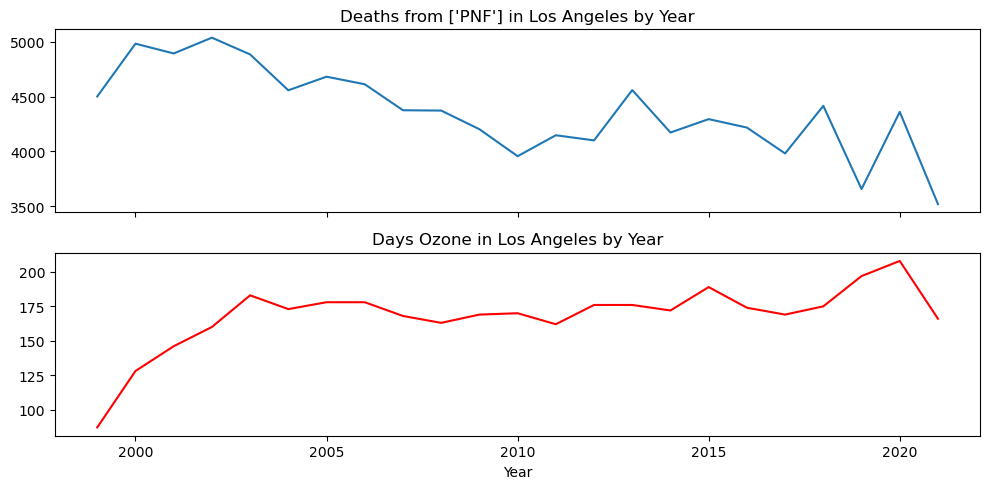

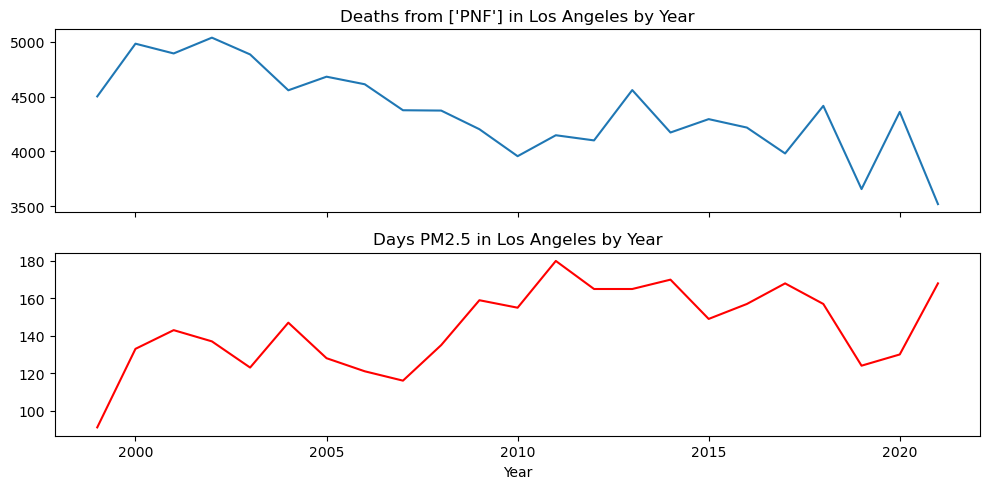

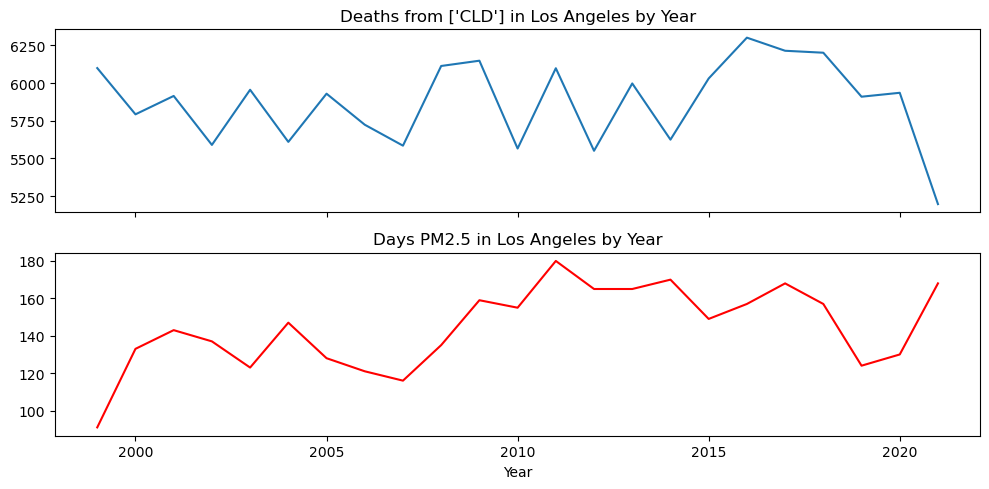

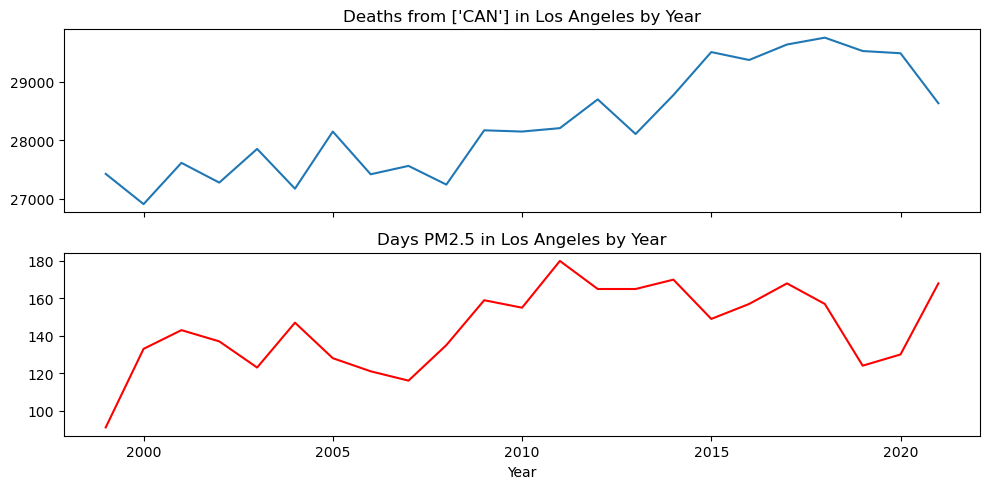

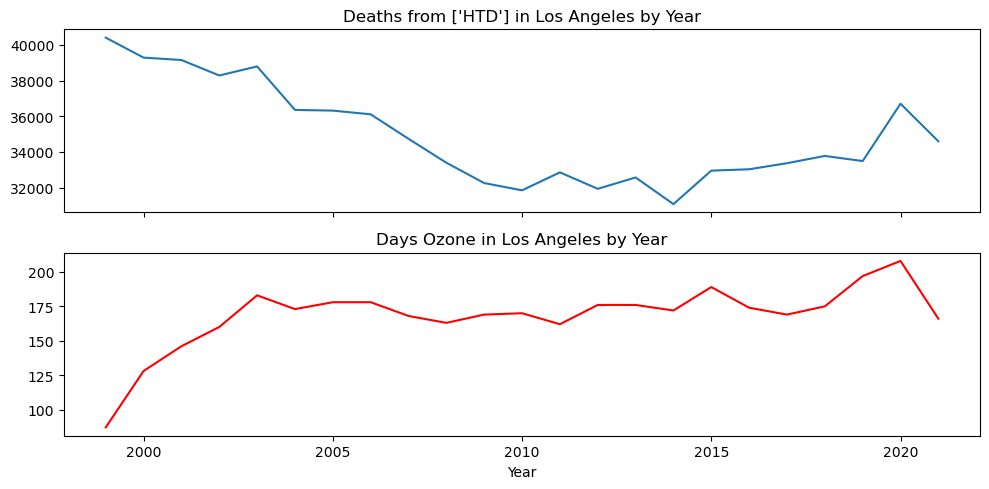

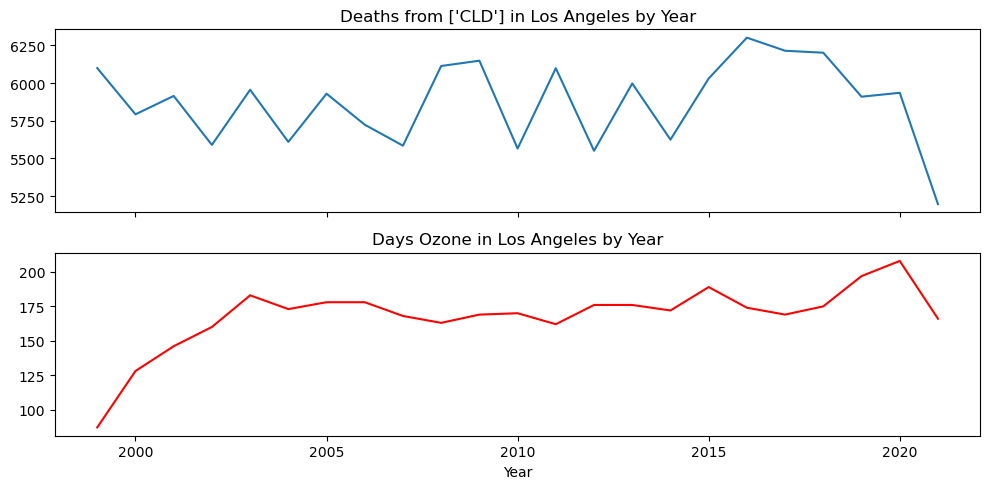

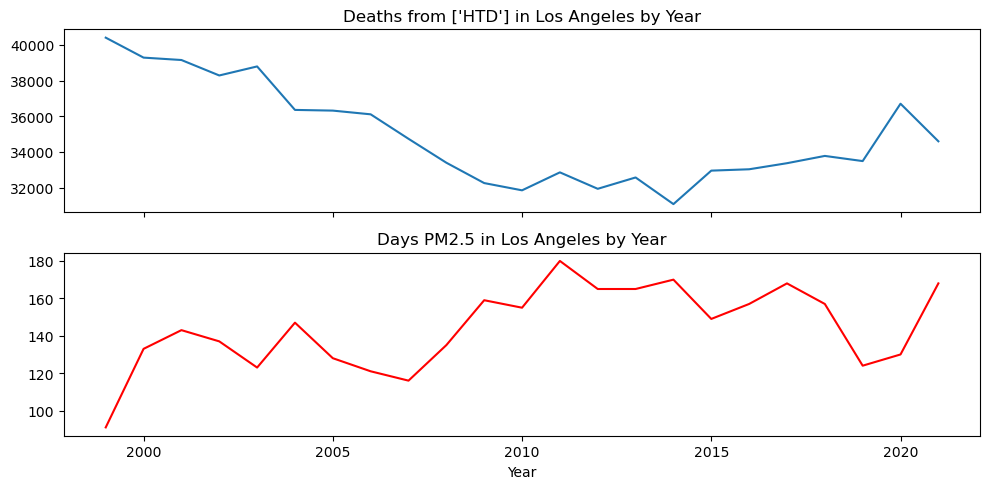

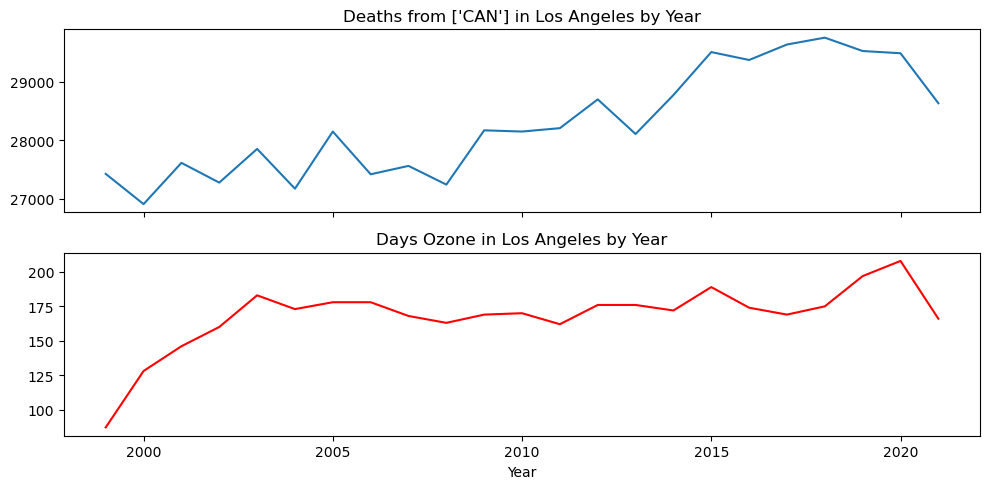

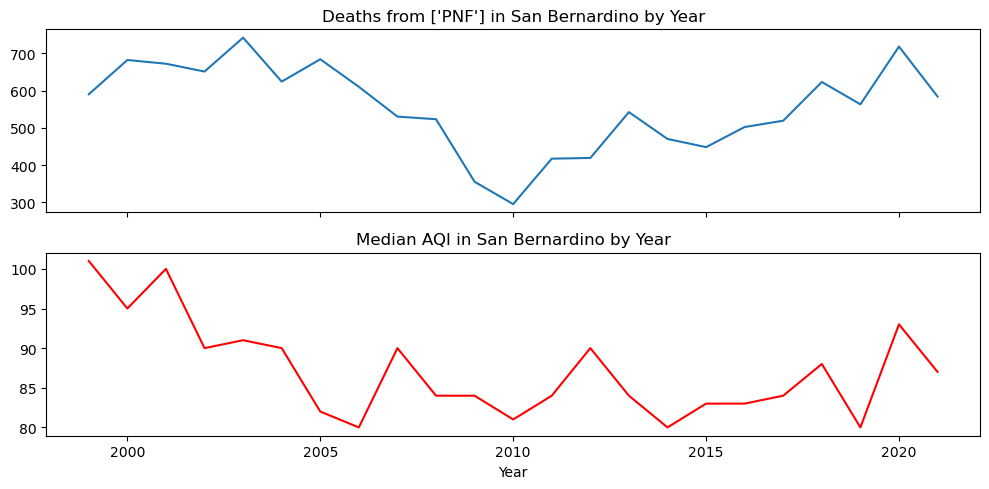

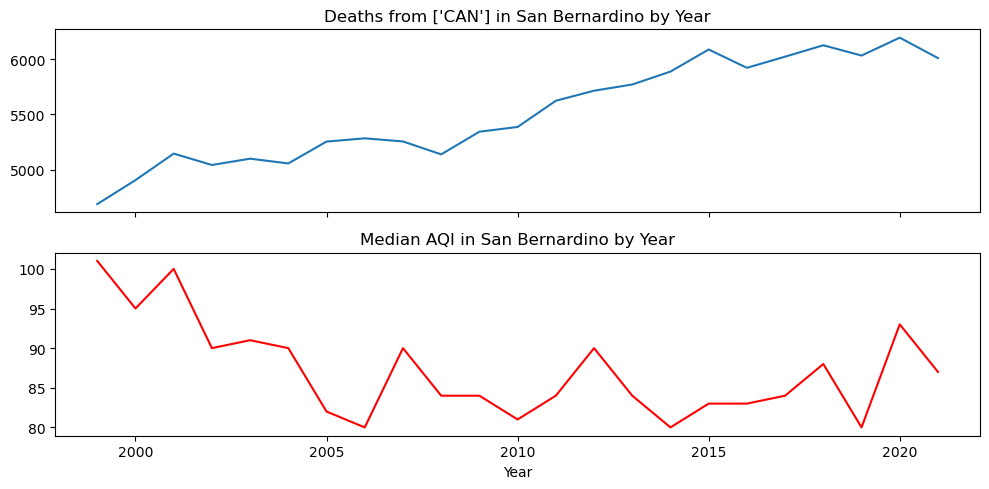

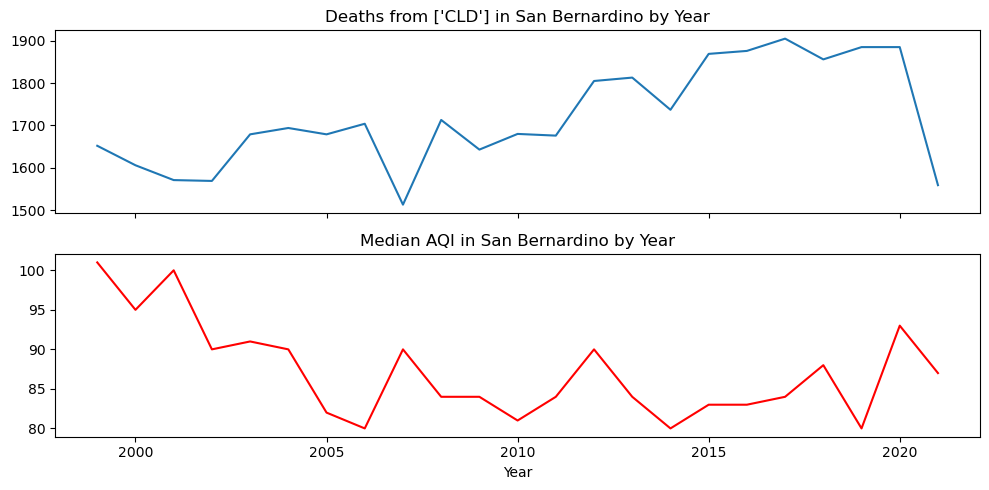

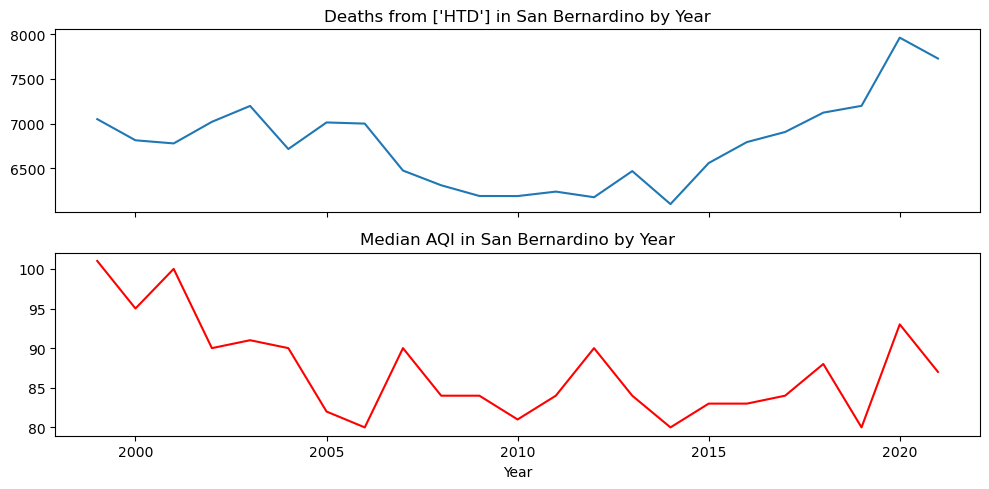

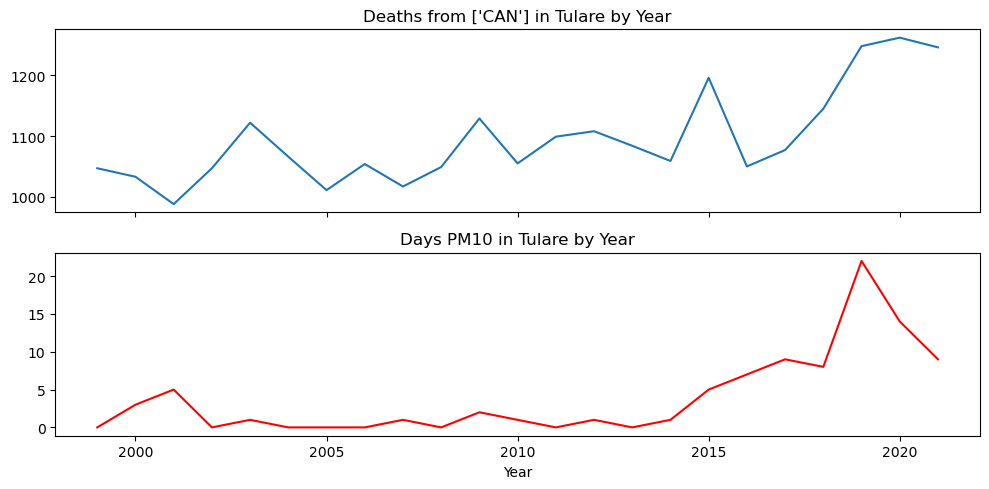

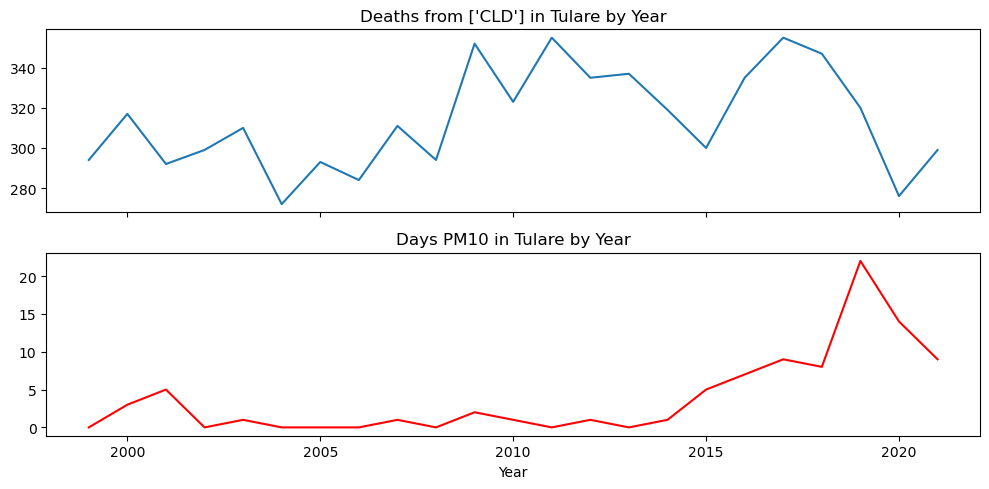

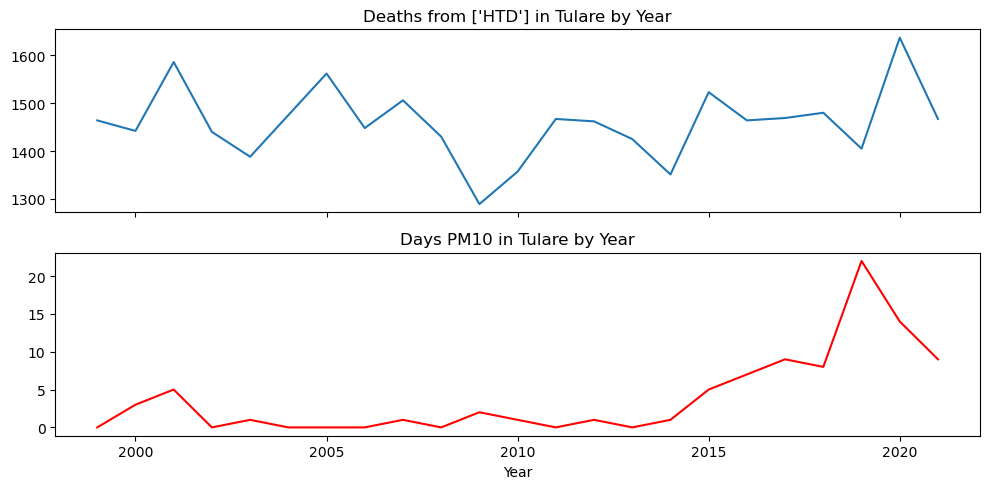

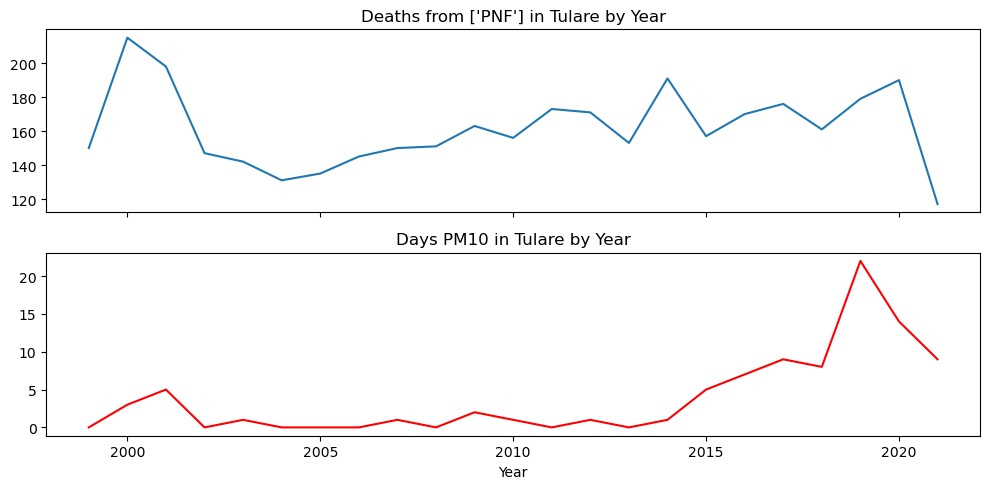

In [1339]:
for county in granger_df.iterrows():
    plot_air_quality_by_county(county[1]['County'], county[1]['air_qual_metric'], [county[1]['Cause']])

# Linear Regression

In [1340]:
# multiple regression model for count of deaths with each air quality feature as a predictor

from sklearn.model_selection import train_test_split
import statsmodels.api as sm


# # features are all air quality columns and all counties
# features = [col for col in cld.select_dtypes(include=np.number).columns if col not in ['Year','Cause', 'Strata', 'Count', 'Annotation_Code', 'Annotation_Desc', 'Days with AQI' ]]

features = ['Days PM2.5', 'Days NO2', 'Days Ozone', 'Days PM10', 'Unhealthy Days']
target = 'Count'

# create X and y
X = can[features]
y = can[target]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# poisson regression model
exog = sm.add_constant(X_train)
model = sm.GLM(y_train, exog, family=sm.families.Poisson())

# fit model
results = model.fit()

# print summary
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                 1023
Model:                            GLM   Df Residuals:                     1017
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.7774e+05
Date:                Tue, 17 Jan 2023   Deviance:                   1.1476e+06
Time:                        00:33:27   Pearson chi2:                 1.62e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.4291      0.008    525.

In [1341]:
# test for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# create X and y
X = can[features]
y = can[target]

# calculate VIF
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

vif

,VIF Factor,features
0,1.763129,Days PM2.5
1,1.246032,Days NO2
2,1.903610,Days Ozone
3,1.079064,Days PM10
4,1.353391,Unhealthy Days


In [1342]:
can[['Year','Count', 'Median AQI']]

,Year,Count,Median AQI
0,1999,193.0,44.0
1,1999,13457.0,97.0
2,1999,38.0,0.0
3,1999,440.0,32.0
4,1999,138.0,64.0
...,...,...,...
1329,2021,430.0,34.0
1330,2021,2348.0,44.0
1331,2021,1276.0,36.0
1332,2021,553.0,48.0
